# Aggregate proteomic data across studies

For best results, first run the [IdentifierUpdates_Proteomics](./IdentifierUpdates_Proteomics.ipynb) notebook first to remove old/obsolete accessions and map to current UniProt database. 
## Load protein table

Run the  notebook first to create the protein table.
Note: Requires internet connection to download information from the UniProt.

## Setup
### Import packages

In [1]:
from collections import defaultdict
from warnings import warn
import re
import pandas as pd

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns


from rbc_gem_utils import (
    ROOT_PATH,
    DATABASE_PATH,
    EXTERNAL_PATH,
    ANNOTATION_PATH,
    INTERIM_PATH,
    check_version,
    check_database_version_online,
    show_versions,
    build_string,
)


from rbc_gem_utils.database.uniprot import (
    UNIPROT_ID_RE,
    UNIPROT_ISOFORM_ID_RE,
    UNIPROT_VERSION_EXPECTED,
    get_version_UniProt,
    query_UniProt,
    get_annotation_to_from_db_UniProt,
    get_label_miriam_mapping_UniProt,
    get_query_fields_UniProt,
    parse_isoforms_UniProt,
    parse_chains_UniProt,
    get_isoform_value_from_entry_UniProt,
)

# Display versions of last time notebook ran and worked
show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

## Check UniProt version
If the version does not match the expected version, it is because database has been updated since the last time this code was utilized. 

### Expected UniProt version: 2024_01
* According to [UniProt](https://www.uniprot.org/help/downloads), updates to the database are made every eight weeks. 
* Last release utilized: [2024_01](https://www.uniprot.org/uniprotkb/statistics) published on **Wed Jan 24 2024**.

In [2]:
if not check_database_version_online("UniProt"):
    warn(
        "Online version of database has been updated since the last time notebook was used."
    )

version = get_version_UniProt()
if check_version(version, UNIPROT_VERSION_EXPECTED, verbose=True):
    database_dirpath = f"{ROOT_PATH}{DATABASE_PATH}"
    annotation_dirpath = f"{ROOT_PATH}{ANNOTATION_PATH}"
else:
    # Use different directory paths for unexpected behavior
    database_dirpath = f"{ROOT_PATH}{INTERIM_PATH}"
    annotation_dirpath = f"{ROOT_PATH}{INTERIM_PATH}"

Current and expected versions match.


## Load aggregated proteomic data, updated IDs

In [3]:
excel_filepath_processed = (
    f"{ROOT_PATH}{EXTERNAL_PATH}/proteomics/proteomics_aggregated.xlsx"
)

### Load table of contents

In [4]:
df_contents = pd.read_excel(
    excel_filepath_processed, sheet_name="Table of Contents", dtype=str
).fillna("")
df_contents

,PubMed/Sheet Name,ID type,Year,Publication,Notes
0,16861337,UniProt,2006,"Pasini EM, Kirkegaard M, Mortensen P, Lutz HU,...",590 IPI;438 UniProt;147 Obsolete --> 441 UniP...
1,18399644,UniProt,2008,"Simó C, Bachi A, Cattaneo A, Guerrier L, Forti...",153 IPI;135 UniProt;18 Obsolete --> 136 UniPr...
2,18494517,UniProt,2008,"Ringrose JH, van Solinge WW, Mohammed S, O'Fla...",699 IPI;400 UniProt;299 Obsolete --> 400 UniP...
3,18614565,UniProt,2008,"Roux-Dalvai F, Gonzalez de Peredo A, Simó C, G...",1577 IPI;1318 UniProt;256 Obsolete --> 1321 U...
4,19778645,UniProt,2009,"van Gestel RA, van Solinge WW, van der Toorn H...",561 GI;473 UniProt;138 Obsolete --> 473 UniPr...
5,22954596,UniProt,2012,"Pesciotta EN, Sriswasdi S, Tang HY, Mason PJ, ...",831 UniProt --> 765 UniProt 2024_01
6,23781972,UniProt,2013,"Pallotta V, D'Alessandro A, Rinalducci S, Zoll...",140 GI;153 UniProt;27 Obsolete --> 153 UniPro...
7,24555563,UniProt,2014,"Lange PF, Huesgen PF, Nguyen K, Overall CM. An...",1220 UniProt --> 1214 UniProt 2024_01
8,26078478,UniProt,2015,"Hegedűs T, Chaubey PM, Várady G, Szabó E, Sara...",419 UniProt --> 416 UniProt 2024_01
9,26474164,UniProt,2015,"Pesciotta EN, Lam HS, Kossenkov A, Ge J, Showe...",1245 UniProt --> 1148 UniProt 2024_01


### Aggregate proteins into table

In [5]:
index_name = "Uniprot"
df_proteins_aggregated = pd.DataFrame([], columns=[index_name])
for _, (sheet_name, id_type) in df_contents[
    ["PubMed/Sheet Name", "ID type"]
].iterrows():
    if id_type != "UniProt":
        warn("Can only utilize UniProt IDs for final aggregation")
        continue
    df = pd.read_excel(excel_filepath_processed, sheet_name=sheet_name, usecols=[0])
    df.columns = [sheet_name]
    df[index_name] = df[sheet_name]
    df_proteins_aggregated = df_proteins_aggregated.merge(
        df, left_on=index_name, right_on=index_name, how="outer"
    )
df_proteins_aggregated = (
    df_proteins_aggregated.drop_duplicates().set_index(index_name).notna()
)
df_proteins_aggregated.columns.name = "pubmed"
df_unreviewed_proteins = df_proteins_aggregated.copy()
df_unreviewed_proteins

pubmed,16861337,18399644,18494517,18614565,19778645,22954596,23781972,24555563,26078478,26474164,...,28689405,30327373,31552303,33103907,33341364,33806028,35858567,36346805,37760001,37942280
Uniprot,,,,,,,,,,,,,,,,,,,,,
A0A024QZ64,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
A0A024R0L6,False,False,False,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
A0A024R1A3,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
A0A024R1I3,False,False,False,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
A0A024R4T4,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V9HWP2,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
X6R390,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
X6R8F3,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


### Query UniProt, keep reviewed proteins

In [6]:
# Extract all relevant information for now and save
query_parameters = {
    "query": " && ".join(
        [
            "(reviewed:true)",
            "(organism_id:9606)",  # Homo sapiens (Human)
        ]
    ),
    "format": "tsv",
    "size": 500,
    "compressed": True,
    "fields": ",".join(
        [
            "reviewed",
            "accession",
            "gene_primary",
        ]
    ),
}

df_results, uniparc, failed_ids, obselete_counts = query_UniProt(
    list(df_unreviewed_proteins.index),
    query_parameters=query_parameters,
    from_db="UniProtKB",
    to_db="UniProtKB",
    return_failed=True,
)

df_results = df_results[df_results["Reviewed"] == "reviewed"].drop_duplicates()
df_results

Fetched: 500 / 4315
Fetched: 1000 / 4315
Fetched: 1500 / 4315
Fetched: 2000 / 4315
Fetched: 2500 / 4315
Fetched: 3000 / 4315
Fetched: 3500 / 4315
Fetched: 4000 / 4315


Number of failed query IDs : 1201


Fetched: 4315 / 4315


,From,Reviewed,Entry,Gene Names (primary)
0,A0A075B6H9,reviewed,A0A075B6H9,IGLV4-69
1,A0A075B6K4,reviewed,A0A075B6K4,IGLV3-10
2,A0A075B6S5,reviewed,A0A075B6S5,IGKV1-27
3,A0A087WSY6,reviewed,A0A087WSY6,IGKV3D-15
4,A0A0A0MRZ8,reviewed,A0A0A0MRZ8,IGKV3D-11
...,...,...,...,...
4310,Q9Y6U3,reviewed,Q9Y6U3,SCIN
4311,Q9Y6V0,reviewed,Q9Y6V0,PCLO
4312,Q9Y6W5,reviewed,Q9Y6W5,WASF2
4313,Q9Y6X8,reviewed,Q9Y6X8,ZHX2


In [7]:
df_reviewed_proteins = df_unreviewed_proteins.loc[df_results["Entry"].values]
df_reviewed_proteins = df_reviewed_proteins.astype(int)
df_reviewed_proteins = df_reviewed_proteins.loc[
    df_reviewed_proteins.sum(axis=1).sort_values(ascending=False).index.values
]
df_reviewed_proteins

pubmed,16861337,18399644,18494517,18614565,19778645,22954596,23781972,24555563,26078478,26474164,...,28689405,30327373,31552303,33103907,33341364,33806028,35858567,36346805,37760001,37942280
Uniprot,,,,,,,,,,,,,,,,,,,,,
P04406,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,1,1
P04040,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,1,1
Q99832,1,1,1,1,1,1,0,1,1,1,...,1,1,0,1,1,1,1,1,1,1
P51148,1,0,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
P11142,1,1,1,1,0,1,1,1,1,1,...,1,1,0,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q15751,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
Q15738,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Q15717,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Export protein table

In [8]:
df_reviewed_proteins.to_csv(
    f"{ROOT_PATH}{EXTERNAL_PATH}/proteomics/proteomic_evidence_table.tsv", sep="\t"
)

### Visualize Protein Table

In [9]:
df_figure_data = pd.read_csv(
    f"{ROOT_PATH}{EXTERNAL_PATH}/proteomics/proteomic_evidence_table.tsv",
    sep="\t",
    index_col=0,
)
df_figure_data.columns.name = "pubmed"
# Order by number of proteins detected in a single study
pubmed_ids_ordered = (
    df_figure_data.sum(axis=0).sort_values(ascending=False).index.values
)
df_figure_data = df_figure_data.loc[:, pubmed_ids_ordered]

# Order by umber of times a single  protein was detected across studies
protein_ids_ordered = (
    df_figure_data.sum(axis=1).sort_values(ascending=False).index.values
)
df_figure_data = df_figure_data.loc[protein_ids_ordered, :]

# Transport for figure
df_figure_data = df_figure_data.T
df_figure_data

Uniprot,P04406,P04040,Q99832,P51148,P11142,P32119,P25786,P69905,P00915,P60953,...,P26010,P26440,P27694,P28065,P28340,P28799,P29353,P29466,P29590,Q13243
pubmed,,,,,,,,,,,,,,,,,,,,,
28689405,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
30327373,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
28263177,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0
37942280,1,1,1,1,1,1,1,1,1,1,...,1,1,1,0,1,0,0,0,0,1
35858567,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
33806028,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
18614565,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,0,1,0
24555563,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,0,0,0
27006477,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,1,0,0,0,0


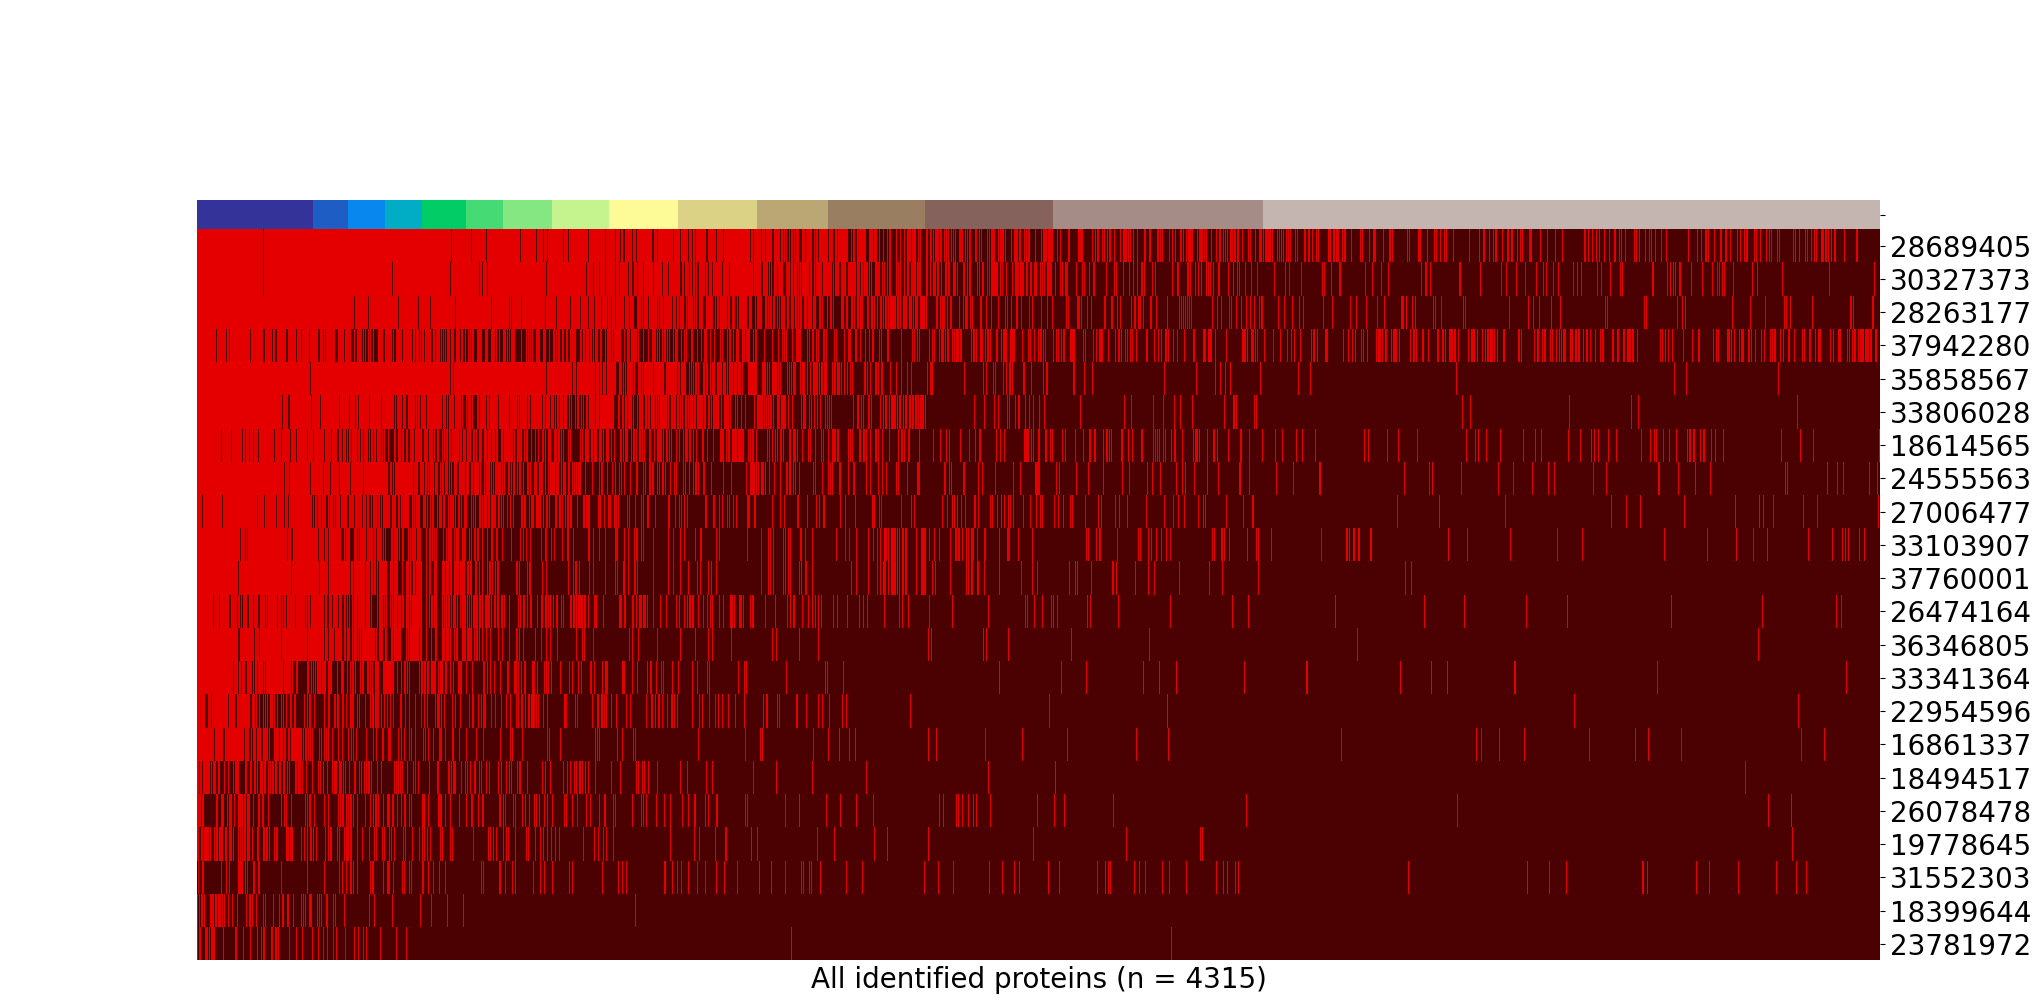

In [10]:
max_pub_count = 15

df_counts_cmap = df_figure_data.sum()
max_val = df_counts_cmap.max()
cmap = mpl.colormaps.get_cmap("terrain_r")

cmin, cmax = (0.05, 1)
cmap_dict = dict(
    zip(
        list(range(max_pub_count + 1)), cmap(np.linspace(cmin, cmax, max_pub_count + 1))
    )
)

cmap_dict.update(
    {
        k: cmap_dict[max_pub_count]
        for k in list(range(max_val + 1))
        if k not in cmap_dict
    }
)
df_counts_cmap = df_counts_cmap.apply(lambda x: cmap_dict[x])

fig_heatmap = sns.clustermap(
    df_figure_data,
    figsize=(20, 10),
    row_cluster=False,
    col_cluster=False,
    cbar_pos=None,
    dendrogram_ratio=(0.1, 0.2),
    col_colors=df_counts_cmap,
    cmap=mpl.colors.ListedColormap(["xkcd:dried blood", "xkcd:red"]),
    xticklabels=False,
)

ax = plt.gca()
ax.set_xlabel(
    f"All identified proteins (n = {len(df_figure_data.columns)})", fontsize=20
)
ax.set_ylabel(None)
ax.yaxis.tick_right()
ax.tick_params(axis="y", labelsize=20)
fig_heatmap;

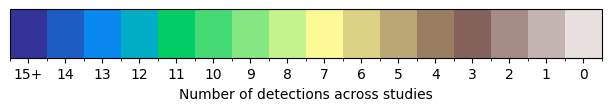

In [11]:
# Colorbar
fig, ax = plt.subplots(figsize=(6, 1), layout="constrained")
cmap = mpl.colormaps.get_cmap("terrain_r")
cmap_colorbar = dict(
    zip(
        list(range(max_pub_count + 1)), cmap(np.linspace(cmax, cmin, max_pub_count + 1))
    )
)
labels = [f"{str(x)}+" if x == max_pub_count else str(x) for x in cmap_colorbar.keys()]
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    "compare", list(cmap_colorbar.values()), max_pub_count + 1
)
norm = mpl.colors.BoundaryNorm(
    np.linspace(0, max_pub_count + 1, max_pub_count + 2), cmap.N
)

colorbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=ax,
    orientation="horizontal",
    label="Number of detections across studies",
)

values = list(cmap_colorbar.keys())
values.reverse()
colorbar.set_ticks(list(np.array(values) + 0.5), labels=labels)
colorbar

#### Look up specific protein
Paste a list of UniProt Identifiers into the string to look up how many times those proteins were detected

In [14]:
plist = """

""".strip().split(
    "\n"
)
df = df_figure_data.T
df = df[df.index.isin(plist)].sum(axis=1)
for x in df.index:
    print(x)
df

Series([], dtype: int64)